#  SARIMA التنبؤ بتطور أسعار البتكوين باستخدام نموذج 


## Importing library

In [45]:
import pandas as pd , numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import plotly.graph_objects as go
import pandas as pd


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import yfinance as yf, seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf

import math
from sklearn.metrics import mean_squared_error

import matplotlib, geopandas as gpd, plotly.express as px, pycountry

## Import Data With Yf

In [3]:
plt.style.use('ggplot')

In [4]:
df=yf.download('BTC-USD')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [10]:
# Data identification
pr_cls=df["2021-01-01":"2022-12-31"]["Adj Close"]

In [11]:
# This is some statistical informations about our database
pr_cls.describe() 

count      730.000000
mean     37817.343060
std      13871.743058
min      15787.284180
25%      23167.444336
50%      38721.625000
75%      47765.391602
max      67566.828125
Name: Adj Close, dtype: float64

## Plotting Data

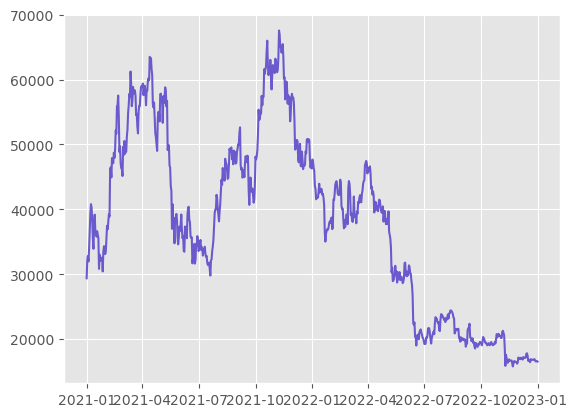

In [6]:
plt.plot(pr_cls.index,pr_cls, color="slateblue")
plt.show()

## Bitcoin trading volume, online exchanges in various countries worldwide in 2020

In [44]:
fig = go.Figure(data=go.Choropleth(
    locations = df3['Code'],
    z = df3['Trading '],
    text = df3['Country'],
    colorscale = 'Blues',   
    autocolorscale=True,
    reversescale=False,
    #marker_line_color='darkgray',
    marker_line_width=0.2,
    colorbar_tickprefix = '$',
    colorbar_title = 'Trading in million US$'))

fig.update_layout(
    title_text='Bitcoin trading volume,on online exchanges in various countries worldwide in 2020',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'))

fig.show()

## Moving average & Moving standred test application

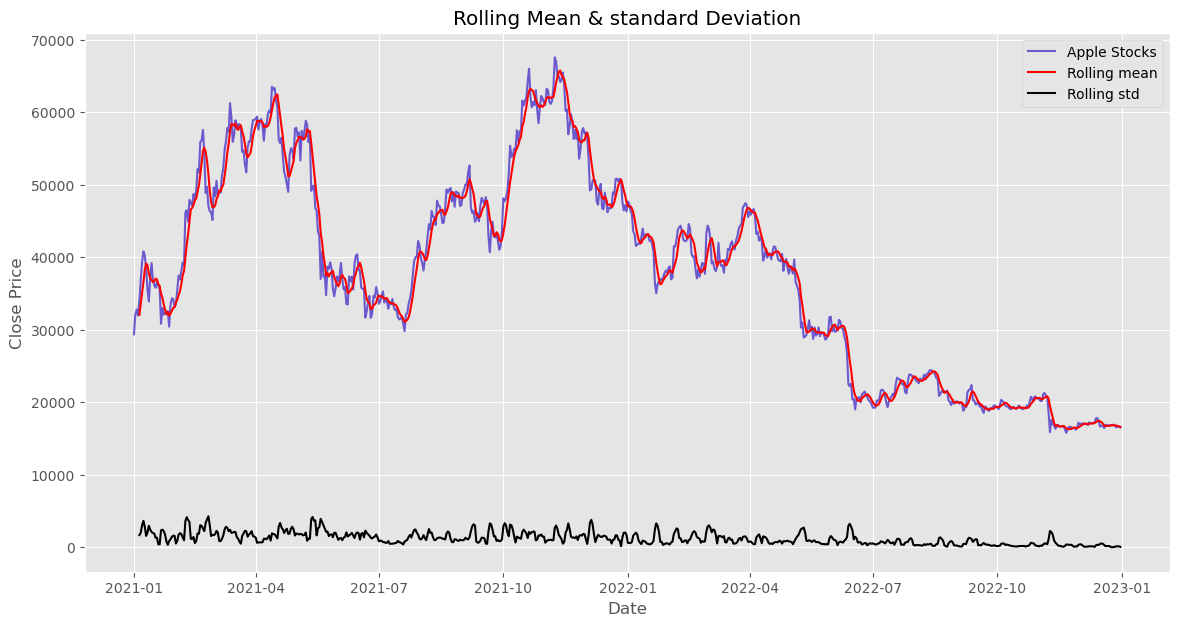

In [9]:
# rolling stat
rolmean=pr_cls.rolling(5).mean()
rollstd=pr_cls.rolling(5).std()

plt.figure(figsize=(14,7))
fig = plt.figure

# plot rolling stat
orig= plt.plot(pr_cls,  color="slateblue",label='Apple Stocks')
mean= plt.plot(rolmean,color='red', label='Rolling mean')
std = plt.plot(rollstd,color='black',label='Rolling std')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.title('Rolling Mean & standard Deviation')
plt.show(block=False)

## Functions for testing stationarity of series

In [13]:
# ADF test at level
def perform_adf_test(series, name,reg):
    '''
    This function gives:
    Regression method
    Serie name
    ADF Statistic
    p-value
    '''
    result = adfuller(series,regression=reg)
    if reg=='c':
        reg='With Constant'
    elif reg=='ct':
        reg='With Trend & Constant'
    else:
        reg='None'
    print('Augmented Dickey-Fuller Test statistics','\nRegression:',reg)
    print(f'Serie name: {name}',f'\nNull Hypothesis: D_{name} has a unit Root',
         '\n(Automatic based on SCIn maxlag=12)')
   
    print('\nADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]>0.05:
        print('\nResult: Serie non Stationary','\n================================')
    else:
        print("\nResult: Serie stationary")
        
# ADF test at first differences
def adf_test_1diff(sr,n,reg):
    '''
    This function gives:
    Regression method
    Serie name
    ADF Statistic
    p-value
    '''
    newsr=sr.diff()[1:]
    result = adfuller(newsr,regression=reg)
    if reg=='c':
        reg='With Constant'
    elif reg=='ct':
        reg='With Trend & Constant'
    else:
        reg='None'
    print('Augmented Dickey-Fuller Test statistics','\nRegression:',reg)
    print(f'Serie name: {n}',f'\nNull Hypothesis: D_{n} has a unit Root',
         '\n(Automatic based on SCIn maxlag=12)')
   
    print('\nADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]>0.05:
        print('\nResult: Serie non Stationary','\n================================')
    else:
        print("\nResult: Serie stationary")


In [11]:
perform_adf_test(pr_cls,'Adj Close','n')

Augmented Dickey-Fuller Test statistics 
Regression: None
Serie name: Adj Close 
Null Hypothesis: D_Adj Close has a unit Root 
(Automatic based on SCIn maxlag=12)

ADF Statistic: -0.688658
p-value: 0.417388

Result: Serie non Stationary 


In [12]:
adf_test_1diff(pr_cls,'D_Adj Close','n')

Augmented Dickey-Fuller Test statistics 
Regression: None
Serie name: D_Adj Close 
Null Hypothesis: D_D_Adj Close has a unit Root 
(Automatic based on SCIn maxlag=12)

ADF Statistic: -27.957947
p-value: 0.000000

Result: Serie stationary


## seasonal decompose (Trend-Seasonal-Resid)

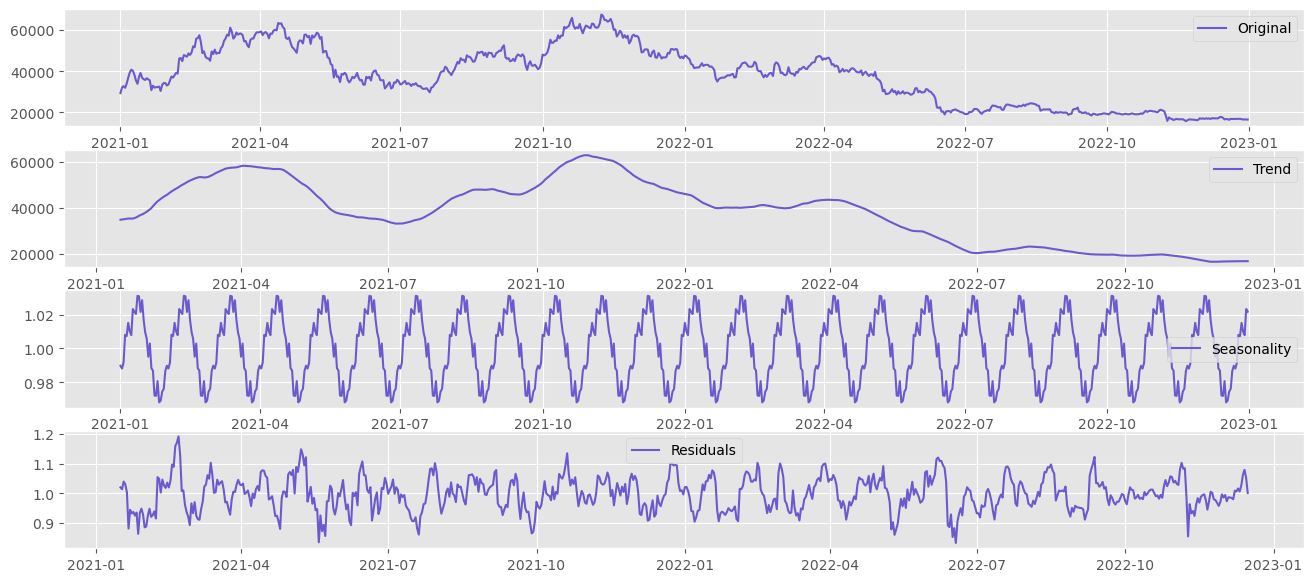

In [13]:
decomposition = seasonal_decompose(pr_cls,model = 'multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(pr_cls, label='Original', color="slateblue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="slateblue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="slateblue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="slateblue")
plt.legend(loc='best')

## Rolling mean and Standred Deviation with first Differencing

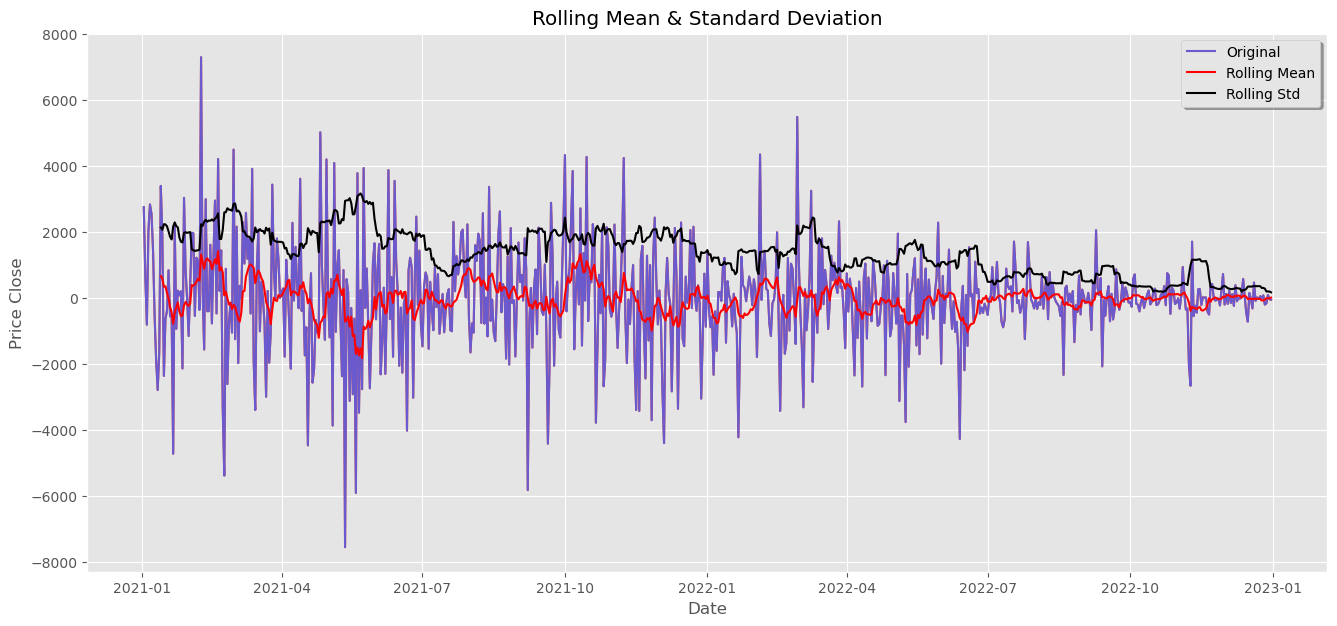

In [15]:
#Lets try differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
pr_cls_Diff = pr_cls - pr_cls.shift()
plt.plot(pr_cls_Diff)

#Determing rolling statistics
rolLmean = pr_cls_Diff.rolling(12).mean()
rolLstd = pr_cls_Diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(pr_cls_Diff, color="slateblue",label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best', shadow=True)
plt.xlabel('Date')
plt.ylabel('Price Close')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## ACF, PACF test

In [15]:

lag_acf = acf(pr_cls, nlags=30)
lag_pacf = pacf(pr_cls, nlags=30)

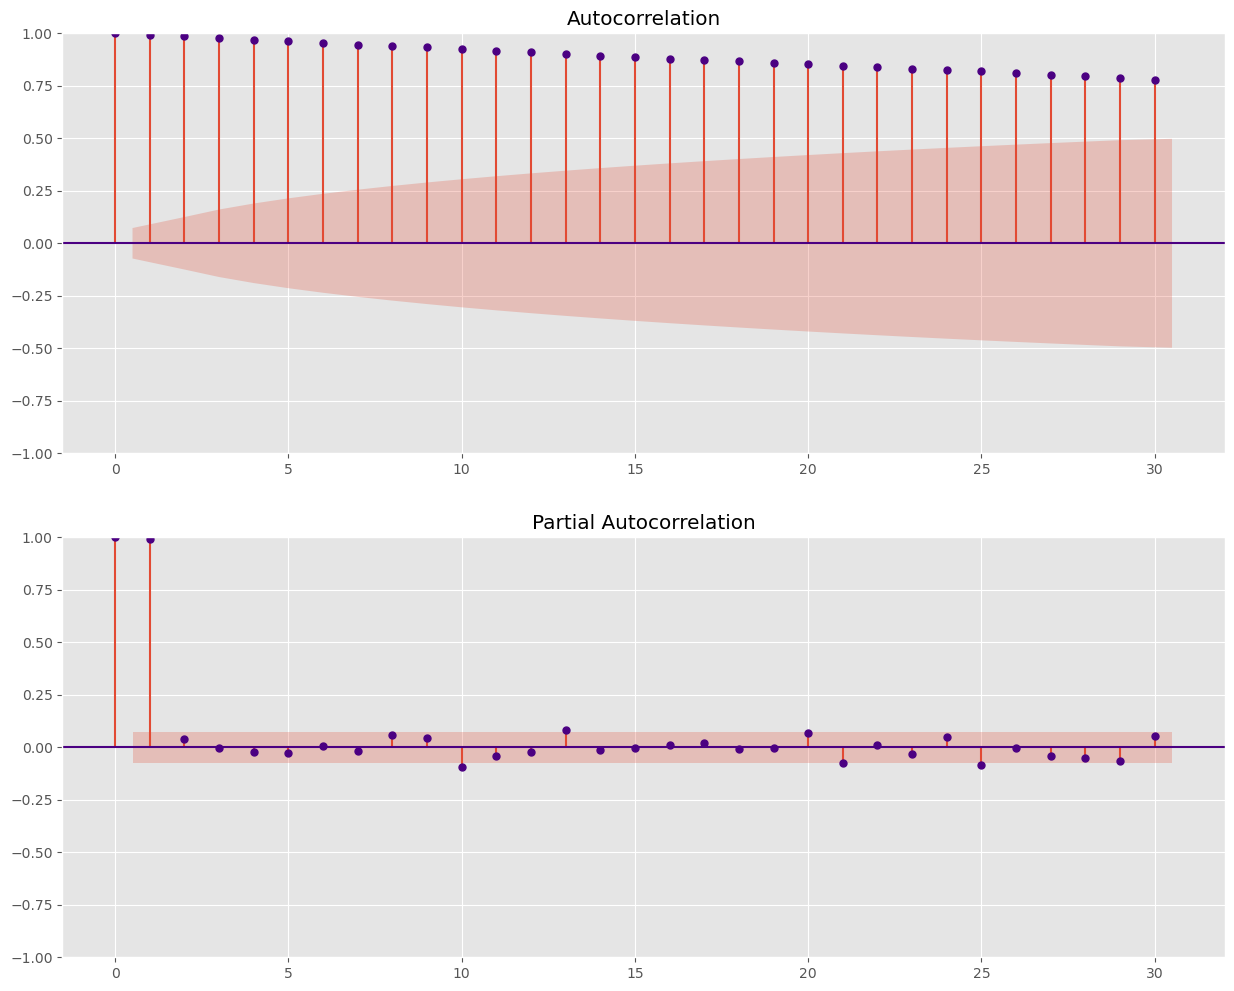

In [16]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pr_cls.dropna(),lags=30,ax=ax1, color="indigo")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pr_cls.dropna(),lags=30,ax=ax2, color="indigo")

In [16]:
# Clear missing values after making the differences
pr_cls_Diff = pr_cls_Diff[~pr_cls_Diff.isnull()]

## Model Building

In [17]:
# this built function will help us to identify values of (p,d,q)(P,D,Q) of SARIMA model
arima_model = auto_arima(pr_cls, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=13102.293, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13101.033, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12864.031, Time=0.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13101.185, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12804.395, Time=1.90 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=12761.678, Time=3.59 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=12755.315, Time=6.41 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=12751.926, Time=10.35 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=20.27 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=12758.333, Time=11.89 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=12762.761, Time=3.11 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=12753.920, Time=12.59 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=inf, Time=14.76 sec
 ARIMA(0,1,1)(5,1,

In [26]:
Model=sm.tsa.statespace.SARIMAX(pr_cls,order=(0,1,1),seasonal_order=(5,1,0,12))
result=md.fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Adj Close   No. Observations:                  730
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood               -6368.960
Date:                             Sun, 22 Jan 2023   AIC                          12751.920
Time:                                     23:20:14   BIC                          12783.946
Sample:                                 01-01-2021   HQIC                         12764.286
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0417      0.034     -1.236      0.216      -0.108       0.024
ar.S.L12      -0.7671      0.022    -34.548      0.000      -0.811      -0.724
ar.S.L24      -0.5403      0.028    -19.255      0.000      -0.595      -0.485
ar.S.L36      -0.3806      0.029    -12.990      0.000      -0.438      -0.323
ar.S.L48      -0.1864      0.028     -6.574      0.000      -0.242      -0.131
ar.S.L60      -0.0867      0.023     -3.761      0.000      -0.132      -0.042
sigma2       2.96e+06   9.95e+04     29.756      0.000    2.76e+06    3.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               443.33
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Note:
As we see at the result, the value of the first component "ma.L1" is not significant
So we'll Re-estimate the model without this component

In [29]:
#Re-estimate the model without "ma.L1"
md=sm.tsa.statespace.SARIMAX(pr_cls,order=(0,1,0),seasonal_order=(5,1,0,12))
result=md.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  730
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -6375.381
Date:                            Sun, 22 Jan 2023   AIC                          12762.761
Time:                                    23:25:38   BIC                          12790.212
Sample:                                01-01-2021   HQIC                         12773.360
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7737      0.019    -41.359      0.000      -0.810      -0.737
ar.S.L24      -0.5427      0.024    -22.957      0.000      -0.589      -0.496
ar.S.L36      -0.3855      0.024    -15.832      0.000      -0.433      -0.338
ar.S.L48      -0.1917      0.024     -8.097      0.000      -0.238      -0.145
ar.S.L60      -0.0918      0.019     -4.708      0.000      -0.130      -0.054
sigma2       2.48e+06   6.97e+04     35.561      0.000    2.34e+06    2.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               440.36
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Ploting Result

In [30]:
result_model=result.fittedvalues.drop('2021-01-02')
plot_result=result_model['2022-10-01':]

<AxesSubplot:xlabel='Date'>

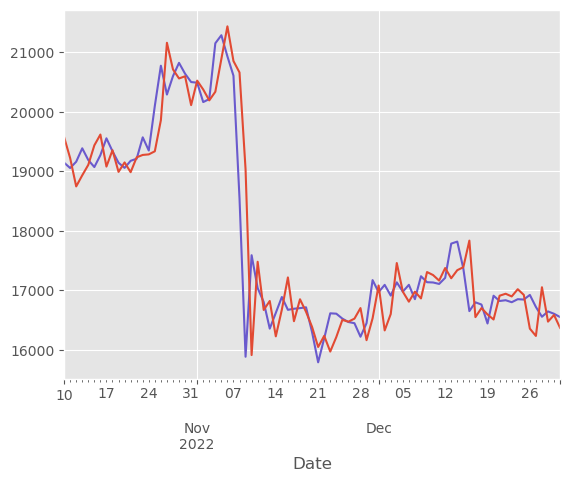

In [31]:
pr_cls["2022-10-10":].plot(color="slateblue",label='Close Price')
plot_result["2022-10-10":].plot()

## Forcasting with ML

In [33]:
# split data 
size= int(len(pr_cls)*0.80)
x_train,x_test=pr_cls[0:size],pr_cls[size:len(pr_cls)]

In [28]:
# Estimate the model
md2=sm.tsa.statespace.SARIMAX(x_train,order=(0,1,0),seasonal_order=(5,1,0,7))
result2=md.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  730
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -6375.381
Date:                            Fri, 13 Jan 2023   AIC                          12762.761
Time:                                    21:33:49   BIC                          12790.212
Sample:                                01-01-2021   HQIC                         12773.360
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7737      0.019    -41.359      0.000      -0.810      -0.737
ar.S.L24      -0.5427      0.024    -22.957      0.000      -0.589      -0.496
ar.S.L36      -0.3855      0.024    -15.832      0.000      -0.433      -0.338
ar.S.L48      -0.1917      0.024     -8.097      0.000      -0.238      -0.145
ar.S.L60      -0.0918      0.019     -4.708      0.000      -0.130      -0.054
sigma2       2.48e+06   6.97e+04     35.561      0.000    2.34e+06    2.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               440.36
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

In [34]:
# train prediction
start_index=0
end_index=len(x_train)-1
train_predection=result.predict(start_index,end_index)

In [35]:
#prediction
start_index1= len(x_train)
end_index1=len(pr_cls)-1
prediction=result.predict(start_index1,end_index1).rename("Predicted prices")

## Plot predictions and actual values

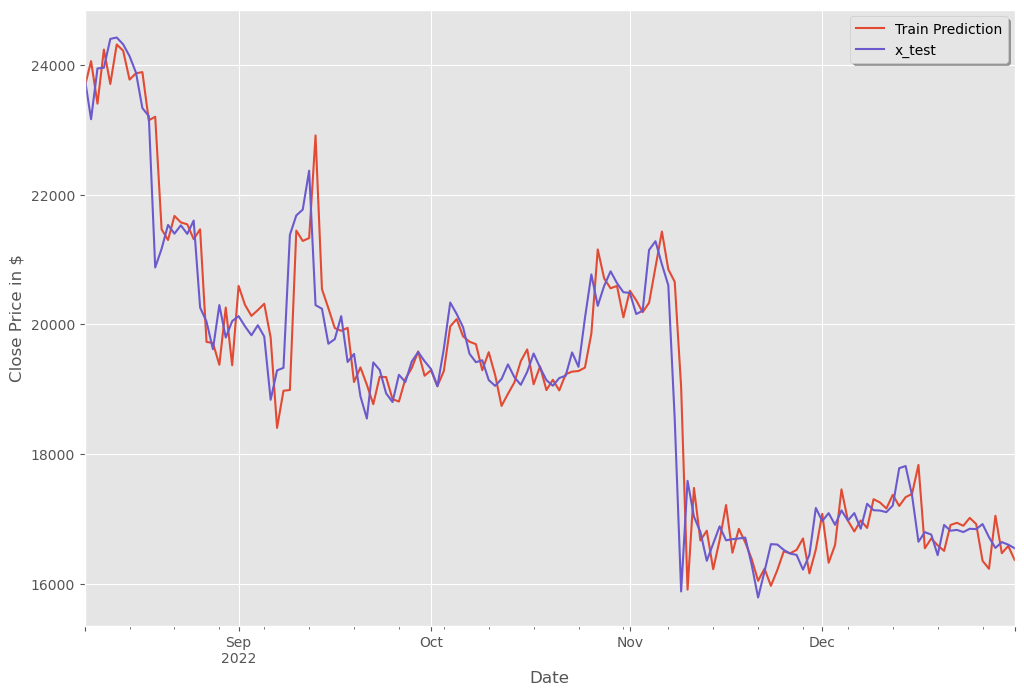

In [31]:
plt.figure(figsize=(12,8))
prediction.plot(label='Train Prediction') 
x_test.plot(label='x_test', color='slateblue')
plt.ylabel('Close Price in $')
plt.xlabel('Date')
plt.legend(shadow=True)

## Mean Squared error (RSME)

In [32]:
trainScore=math.sqrt(mean_squared_error(x_train,train_predection))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(x_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2330.22 RMSE
Test Score: 633.99 RMSE


## Graphical representation of prediction values

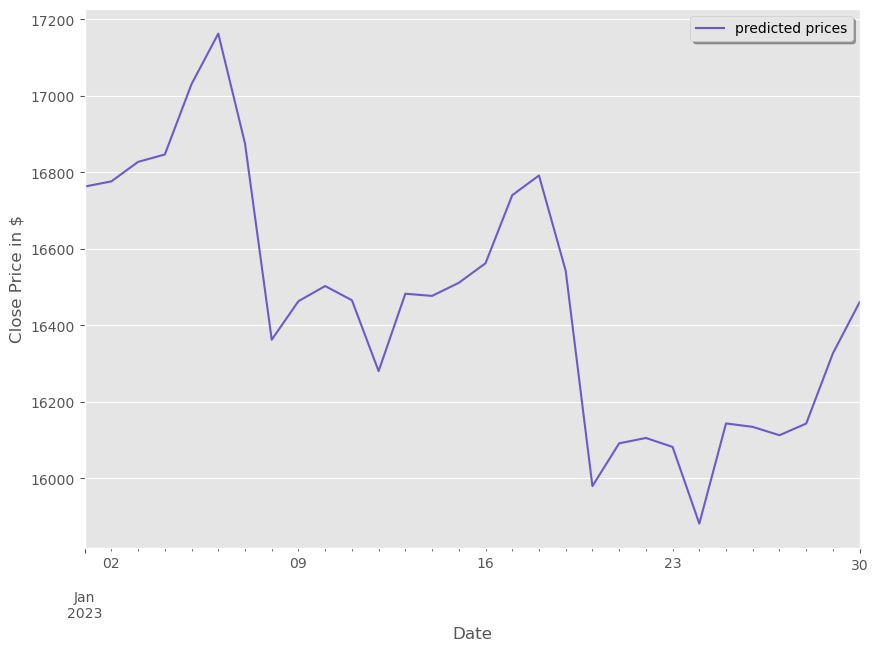

In [36]:
forecast1 = result.predict(start = len(pr_cls),  
                          end = (len(pr_cls)-1) + 30,typ = 'levels')
plt.figure(figsize=(10,7))
plt.ylabel('Close Price in $')
plt.xlabel('Date')

forecast1.plot(color="slateblue",label='predicted prices')
plt.legend(shadow=True)

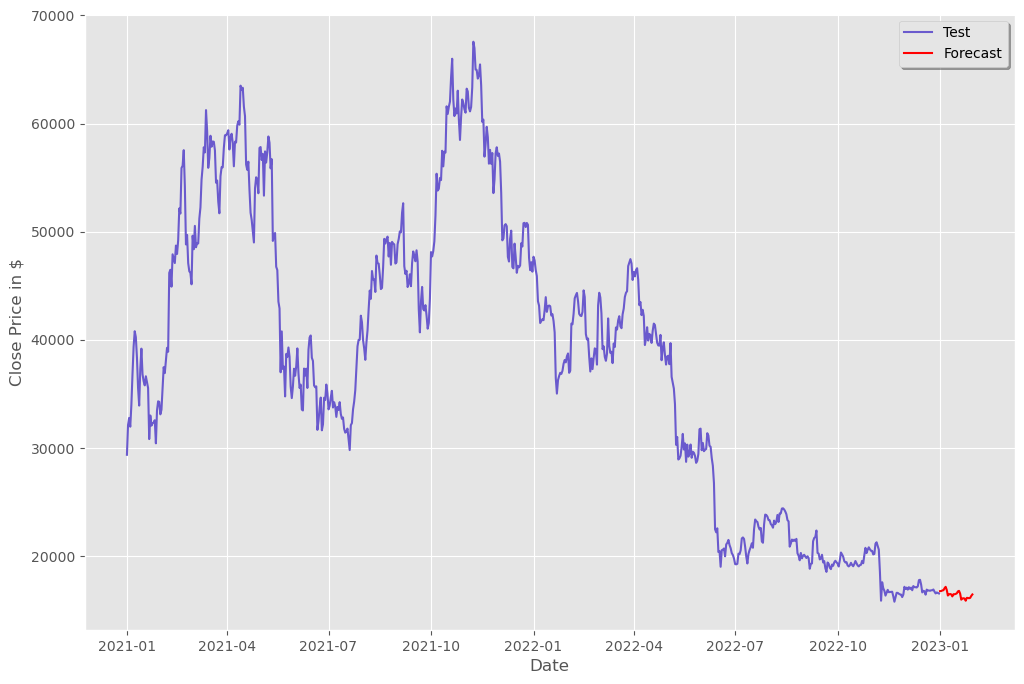

In [39]:
plt.figure(figsize=(12,8))
plt.plot(pr_cls, label='Test', color='slateblue')
plt.plot(forecast1, label='Forecast', color='red')
plt.legend(loc='best', shadow=True)
plt.ylabel('Close Price in $')
plt.xlabel('Date')
plt.show()
# Forecasting Data with red color

## Diagnostics Plot

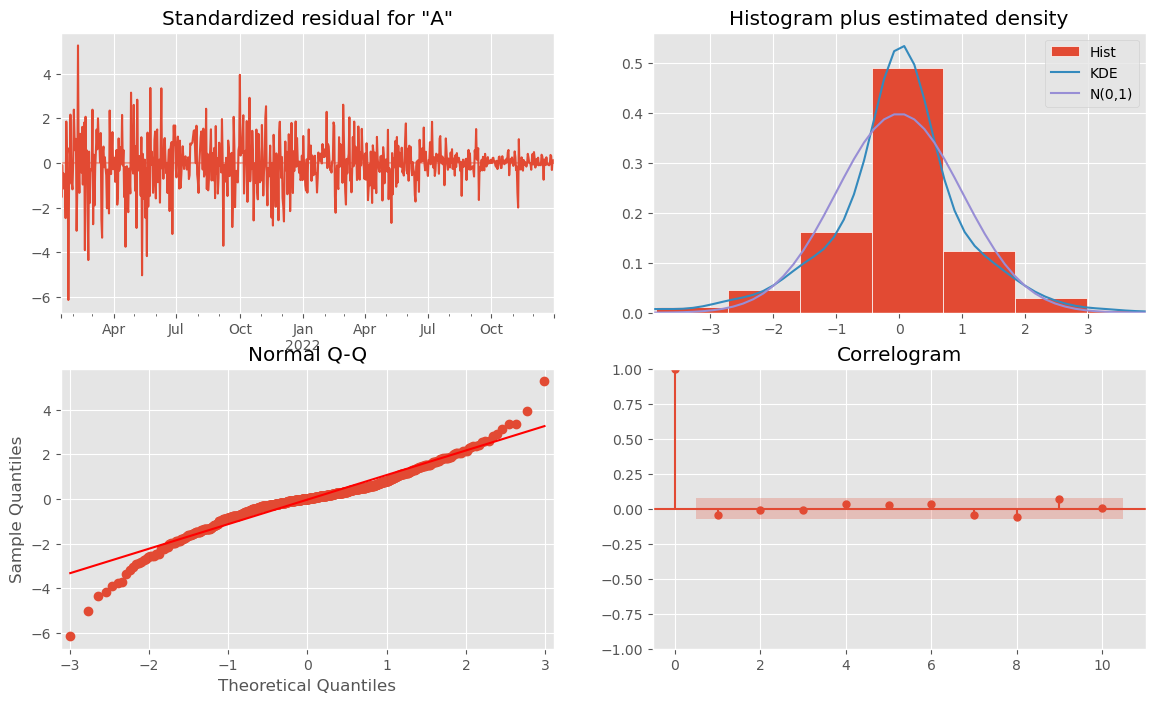

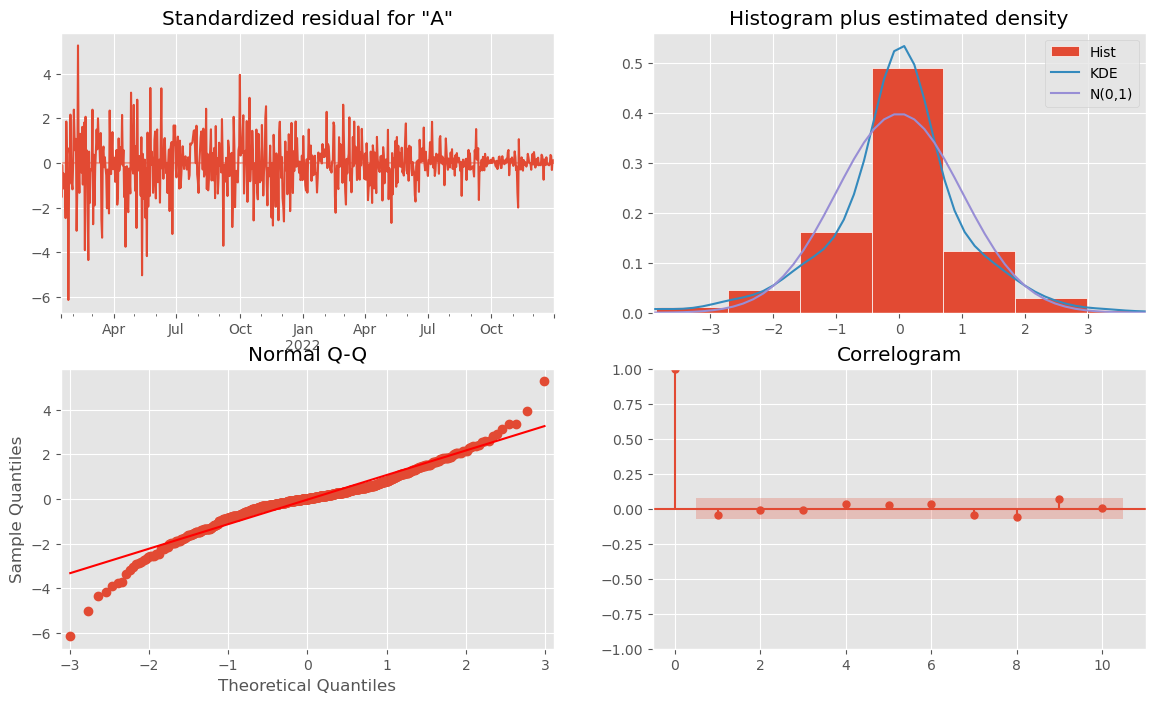

In [337]:
result.plot_diagnostics(figsize=(14,8))

# Thanks

In [40]:
df3= pd.read_excel('geo.xlsx')
#df3.set_index('Country', inplace=True)
df3.head()

,Country,Trading,Code
0,Unites States,1523.60,USA
1,Russia,421.38,RUS
2,Nigeria,400.08,NGA
3,China,198.26,CHN
4,United kingdom,198.26,GBR
